# Classification problem
### Considering binary gender classification
(0) Male

(1) Female

In [4]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [5]:
import utils

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold



%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = pd.DataFrame()

In [7]:
def import_data(fisher):
    if fisher == True:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices_fisher200.csv',index_col=['Institution','Subject'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    else:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices200.csv',index_col=['Institution','Subject','Run'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    return df,phenotypic

In [18]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['DX']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['DX'])
df[df.DX >= 1] = 1

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.DX).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])
X_TEST =  np.tanh(TEST.iloc[:,:-3])
y_TEST =  (TEST.DX).apply(lambda x: int(x))

In [19]:
ROI_labels = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/ROI_labels.csv')

In [35]:
y.value_counts()

0    459
1    268
Name: DX, dtype: int64

In [20]:
for i in range(len(y.value_counts())):
    print(' {} = {:.2f}% \n'.format(i,y.value_counts()[i]/len(y)))

 0 = 0.63% 

 1 = 0.37% 



In [21]:
from sklearn.model_selection import train_test_split

# Validation and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

In [22]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X, y, cv=cv, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy in test:0.63(0.00)
F1_scores 0.39(0.00)
Precision_scores 0.32(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)
Dummy accuracy score in TEST set: 0.6667


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Logistic Regression accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, logreg.predict(X_TEST))))

Logistic Regression accuracy score in training set: 1.0000
Logistic Regression accuracy score in val set: 1.0000
Logistic Regression accuracy score in TEST set: 1.0000


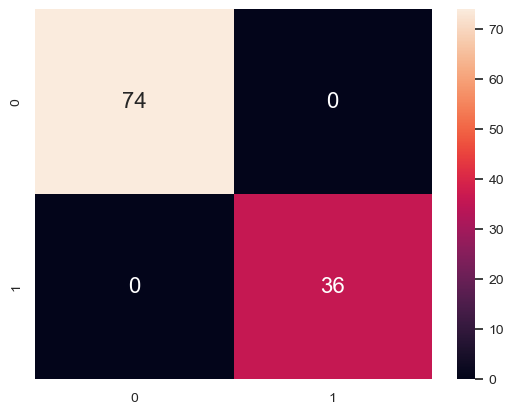

In [24]:
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

### Cross Validation

In [25]:
scores = cross_validate(logreg, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:1.00(0.00)
F1_scores 1.00(0.00)
Precision_scores 1.00(0.00)
Recall_scores 1.00(0.00)
ROC AUC 1.00(0.00)


In [26]:
scores['Model'] = ['logreg']*10
results = pd.concat([results, pd.DataFrame.from_dict(scores)],axis=1)

In [27]:
y_score = logreg.predict_proba(X_test)

y_score = y_score[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

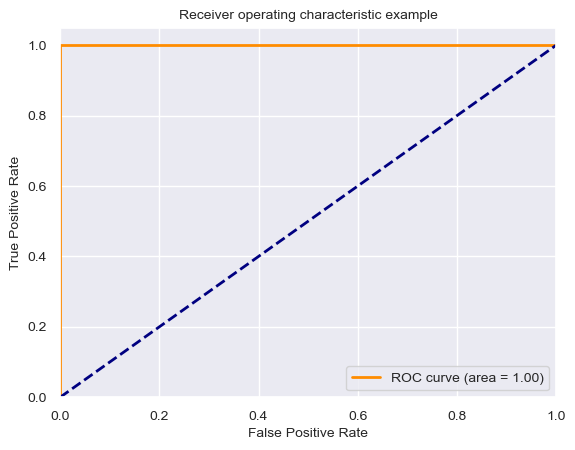

In [28]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [43]:
(logreg.coef_[0]).argsort()[-100:][::-1]

array([11240, 11242, 17001, 16922, 16920,  8710, 15894, 15354, 11209,
        8658, 11221, 10650,  7742,  8702,  7659,  9653, 11210,   889,
        6349, 12188, 15189,  6447, 17086,  7780,  9758, 17483, 15123,
         782, 15938,  7542, 15113,  7602,  7706,  7594, 13157,  7877,
       12224, 15208, 10631,  7844, 13097, 15945, 13044, 15115,  7795,
        9264, 13433, 14487,   818, 17743,  1535,  8729,   937,  4792,
        5251,  7217, 12262,  6969, 13488, 15750,  6423,  1112,  9773,
        2372,  3141, 15896, 11284,  3105,  7010,   966, 16970, 17055,
       13159, 15889,  9692, 15759,  9234, 13423,  6933,  9713,  9179,
        6328,  8767, 15875, 12249,  9798,  7592,  4906, 16300,  9582,
        6331,  7941,  7891, 16463,  6436,  7075,  7020,  4797, 16607,
       12635])

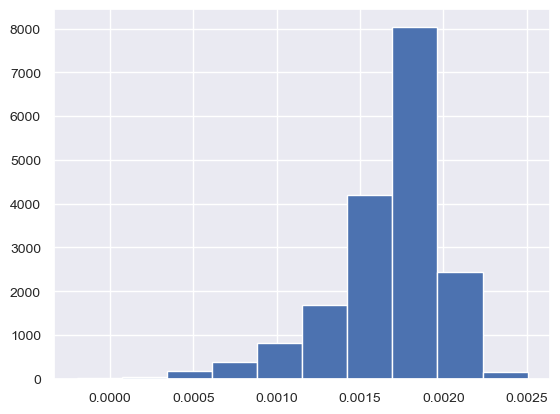

In [45]:
# get importance
importance = logreg.coef_[0]
#importance = np.sort(importance)

plt.hist(importance)
plt.show()

## SVM

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "C": [0, 0.25, 1, 5, 10],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
}


svc = SVC(gamma='auto')
#svc.fit(X_train, y_train)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = GridSearchCV(estimator = svc, param_grid = random_grid,
                               cv = 3, verbose=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

#y_pred = svc.predict(X_test)

#print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
#print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/si

GridSearchCV(cv=3, estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [0, 0.25, 1, 5, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [31]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 100.00%


In [32]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/SVC_params.csv')

{'C': 0.25, 'kernel': 'linear'}


In [33]:
# Best SVC model
svc = SVC(
    **rf_random.best_params_,
    gamma="auto"
)

scores = cross_validate(svc, X_train, y_train.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


In [34]:
print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:1.00(0.00)
F1_scores 1.00(0.00)
Precision_scores 1.00(0.00)
Recall_scores 1.00(0.00)
ROC AUC 1.00(0.00)


In [69]:
scores['Model'] = ['SVC']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

## MLP

In [44]:
from sklearn.neural_network import MLPClassifier

# Best SVC model
mlp = MLPClassifier(hidden_layer_sizes=(100,64,32,16),solver='adam',learning_rate='adaptive', shuffle=False, alpha=1, early_stopping=True)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, mlp.predict(X_train))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
#print('Logistic Regression accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, mlp.predict(X_TEST))))

#scores = cross_validate(mlp, X_train, y_train.values.ravel(), scoring=scoring,
#                         cv=cv, n_jobs=-1,verbose=1)


Logistic Regression accuracy score in training set: 1.0000
Logistic Regression accuracy score in val set: 1.0000


In [ ]:
scores = cross_validate(mlp, X_train, y_train.values.ravel(), scoring=scoring,
                        cv=cv, n_jobs=-1,verbose=1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

### XGBoost

In [45]:
# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "max_depth": [1, 2, 4, 8],
    "learning_rate": [0.001,0.05, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0.001, 1, 10],
    "scale_pos_weight": [0,1, 3],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]

}

# Using  Boosted trees
bst = XGBClassifier(booster='gbtree',tree_method='exact',objective='binary:logistic',n_jobs=-1)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = bst, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'gamma': [0, 0.25, 1],
                                        'learning_rate': [0.001, 0.05, 0.5],
                                        'max_depth': [1, 2, 4, 8],
                                        'n_estimators': [200, 600, 1000],
                                        'reg_lambda': [0.001, 1, 10],
                                        'scale_pos_weight': [0, 1, 3],
                                        'subsample': [0.8]},
                   random_state=42, verbose=1)

In [46]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 69.36%


In [107]:
a = {'subsample': 0.8,
                         'scale_pos_weight': 1, 'reg_lambda': 0.001, 'n_estimators': 1000,
                         'max_depth': 1, 'learning_rate': 0.05, 'gamma': 0.25, 'colsample_bytree': 0.8}

In [108]:
a

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'reg_lambda': 0.001,
 'n_estimators': 1000,
 'max_depth': 1,
 'learning_rate': 0.05,
 'gamma': 0.25,
 'colsample_bytree': 0.8}

In [117]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/xgboost_params.csv')

In [111]:
# Best xgboosting model
final_cl = XGBClassifier(
    **rf_random.best_params_,
    objective="binary:logistic",
    booster='gbtree',
    tree_method='exact',
    eval_metric='mlogloss',
    n_jobs=-1
)
# **rf_random.best_params_

scores = cross_validate(final_cl, X_train, y_train.values.ravel(), scoring=scoring,
                         cv=5, n_jobs=-1,verbose=1)

#bst.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


In [112]:
print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:0.68(0.03)
F1_scores 0.62(0.03)
Precision_scores 0.67(0.04)
Recall_scores 0.62(0.03)
ROC AUC 0.73(0.03)


In [113]:
scores['Model'] = ['XGBoost']*5
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [117]:
results

,fit_time,score_time,test_acc,test_prec_macro,test_rec_macro,test_f1,test_roc_auc,Model
0,3.510035,0.109687,0.726027,0.746032,0.657942,0.660859,0.673726,logreg
1,3.260859,0.119483,0.710345,0.706522,0.644994,0.648058,0.799145,logreg
2,2.810567,0.124903,0.662069,0.631108,0.610297,0.612194,0.655271,logreg
3,2.374278,0.142166,0.648276,0.656863,0.539072,0.482903,0.773911,logreg
4,3.313388,0.116192,0.710345,0.689413,0.686406,0.687756,0.776760,logreg
5,3.920038,1.603890,0.709677,0.690858,0.687483,0.688963,0.733352,SVC
6,3.893258,1.603751,0.733871,0.725163,0.690384,0.697494,0.757668,SVC
7,3.583603,1.374703,0.715447,0.715038,0.660134,0.664327,0.760078,SVC
8,3.924670,1.600512,0.666667,0.652086,0.657195,0.653474,0.773796,SVC
9,3.868637,1.615952,0.764228,0.751832,0.732919,0.739350,0.828063,SVC


In [118]:
results.to_csv('/Users/rodrigo/Post-Grad/CC400/Results/models_adhd.csv')